In [1]:
import numpy as np
import pandas as pd
import re
import nltk
import spacy
import string
import theano
pd.options.mode.chained_assignment = None

# Let us load our data file

In [2]:

full_df = pd.read_csv("train-balanced-sarcasm.csv")

In [3]:
df = full_df[["text"]]
df["text"] = df["text"].astype(str) #declaring the contents in the col --
#--> "text" as a string variable.

full_df.head() # lets see what our rows and cols look like. 

,label,text,author,subreddit,score,ups,downs,date,created_utc,parent_comment
0,0,NC and NH.,Trumpbart,politics,2,-1,-1,2016-10,2016-10-16 23:55:23,"Yeah, I get that argument. At this point, I'd ..."
1,0,You do know west teams play against west teams...,Shbshb906,nba,-4,-1,-1,2016-11,2016-11-01 00:24:10,The blazers and Mavericks (The wests 5 and 6 s...
2,0,"They were underdogs earlier today, but since G...",Creepeth,nfl,3,3,0,2016-09,2016-09-22 21:45:37,They're favored to win.
3,0,"This meme isn't funny none of the ""new york ni...",icebrotha,BlackPeopleTwitter,-8,-1,-1,2016-10,2016-10-18 21:03:47,deadass don't kill my buzz
4,0,I could use one of those tools.,cush2push,MaddenUltimateTeam,6,-1,-1,2016-12,2016-12-30 17:00:13,Yep can confirm I saw the tool they use for th...


# In order for us to model language and predict sarcasm, we must first wrangle and clean our data.

### We will first start with lower casing our "text". This will treat the string 'text', 'Text', 'TEXT' homogeneously. 

In [4]:
df["text_lower"] = df["text"].str.lower()
df.head()

,text,text_lower
0,NC and NH.,nc and nh.
1,You do know west teams play against west teams...,you do know west teams play against west teams...
2,"They were underdogs earlier today, but since G...","they were underdogs earlier today, but since g..."
3,"This meme isn't funny none of the ""new york ni...","this meme isn't funny none of the ""new york ni..."
4,I could use one of those tools.,i could use one of those tools.


### Now we will remove the following symbols 
 #### --> string.punctuation includes #$%&\'()*+,-./:;<=>?@[\\]^_{|}~`" 

In [5]:
# drop the new column created in last cell
df.drop(["text_lower"], axis=1, inplace=True)

In [6]:
PUNCT_TO_REMOVE = string.punctuation
def remove_punctuation(text):
    """custom function to remove the punctuation"""
    return text.translate(str.maketrans('', '', PUNCT_TO_REMOVE))

df["text_wo_punct"] = df["text"].apply(lambda text: remove_punctuation(text))
df.head()

,text,text_wo_punct
0,NC and NH.,NC and NH
1,You do know west teams play against west teams...,You do know west teams play against west teams...
2,"They were underdogs earlier today, but since G...",They were underdogs earlier today but since Gr...
3,"This meme isn't funny none of the ""new york ni...",This meme isnt funny none of the new york nigg...
4,I could use one of those tools.,I could use one of those tools


### Now we will remove stop words like "the", "a", "I" to help with accuracy

In [7]:
from nltk.corpus import stopwords
nltk.download('stopwords')
", ".join(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/valazeinali/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


"i, me, my, myself, we, our, ours, ourselves, you, you're, you've, you'll, you'd, your, yours, yourself, yourselves, he, him, his, himself, she, she's, her, hers, herself, it, it's, its, itself, they, them, their, theirs, themselves, what, which, who, whom, this, that, that'll, these, those, am, is, are, was, were, be, been, being, have, has, had, having, do, does, did, doing, a, an, the, and, but, if, or, because, as, until, while, of, at, by, for, with, about, against, between, into, through, during, before, after, above, below, to, from, up, down, in, out, on, off, over, under, again, further, then, once, here, there, when, where, why, how, all, any, both, each, few, more, most, other, some, such, no, nor, not, only, own, same, so, than, too, very, s, t, can, will, just, don, don't, should, should've, now, d, ll, m, o, re, ve, y, ain, aren, aren't, couldn, couldn't, didn, didn't, doesn, doesn't, hadn, hadn't, hasn, hasn't, haven, haven't, isn, isn't, ma, mightn, mightn't, mustn, mus

In [8]:
STOPWORDS = set(stopwords.words('english'))
def remove_stopwords(text):
    """custom function to remove the stopwords"""
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])

df["text_wo_stop"] = df["text_wo_punct"].apply(lambda text: remove_stopwords(text))
df.head()

,text,text_wo_punct,text_wo_stop
0,NC and NH.,NC and NH,NC NH
1,You do know west teams play against west teams...,You do know west teams play against west teams...,You know west teams play west teams east teams...
2,"They were underdogs earlier today, but since G...",They were underdogs earlier today but since Gr...,They underdogs earlier today since Gronks anno...
3,"This meme isn't funny none of the ""new york ni...",This meme isnt funny none of the new york nigg...,This meme isnt funny none new york nigga ones
4,I could use one of those tools.,I could use one of those tools,I could use one tools


### Lets see what some frequent words are and remove them

In [9]:
#import matplotlib.pyplot as plt
#%matplotlib inline
#%pylab inline

from collections import Counter
cnt = Counter()
for text in df["text_wo_stop"].values:
    for word in text.split(): # going through every word in every tweet
        cnt[word] += 1
cnt.most_common(10)
        
        #### Changes made by *VALA ####
        ## Lets make Histogram of most frequent words
    #y_pos = word
    #freq = cnt[word] #get the freq of the words
        
    #plt.bar(y_pos,freq, align = 'center', alpha = .5)
    #plt.xticks(y_pos, word)
    #plt.ylabel('Frequent Words')
    #plt.title('Most frequent words in our Twitter data set')
        
    #plt.show()      

[('I', 169221),
 ('like', 53550),
 ('dont', 36745),
 ('people', 34167),
 ('would', 34048),
 ('Yeah', 33124),
 ('get', 32644),
 ('Im', 30655),
 ('one', 29323),
 ('But', 27309)]

In [10]:
FREQWORDS = set([w for (w, wc) in cnt.most_common(10)])
def remove_freqwords(text):
    """custom function to remove the frequent words"""
    return " ".join([word for word in str(text).split() if word not in FREQWORDS])

df["text_wo_stopfreq"] = df["text_wo_stop"].apply(lambda text: remove_freqwords(text))
df.head()

,text,text_wo_punct,text_wo_stop,text_wo_stopfreq
0,NC and NH.,NC and NH,NC NH,NC NH
1,You do know west teams play against west teams...,You do know west teams play against west teams...,You know west teams play west teams east teams...,You know west teams play west teams east teams...
2,"They were underdogs earlier today, but since G...",They were underdogs earlier today but since Gr...,They underdogs earlier today since Gronks anno...,They underdogs earlier today since Gronks anno...
3,"This meme isn't funny none of the ""new york ni...",This meme isnt funny none of the new york nigg...,This meme isnt funny none new york nigga ones,This meme isnt funny none new york nigga ones
4,I could use one of those tools.,I could use one of those tools,I could use one tools,could use tools


## Now lets remove some rare words

In [11]:
# Drop the two columns which are no more needed 
df.drop(["text_wo_punct", "text_wo_stop"], axis=1, inplace=True)

n_rare_words = 10
RAREWORDS = set([w for (w, wc) in cnt.most_common()[:-n_rare_words-1:-1]])
def remove_rarewords(text):
    """custom function to remove the rare words"""
    return " ".join([word for word in str(text).split() if word not in RAREWORDS])

df["text_wo_stopfreqrare"] = df["text_wo_stopfreq"].apply(lambda text: remove_rarewords(text))
df.head()

,text,text_wo_stopfreq,text_wo_stopfreqrare
0,NC and NH.,NC NH,NC NH
1,You do know west teams play against west teams...,You know west teams play west teams east teams...,You know west teams play west teams east teams...
2,"They were underdogs earlier today, but since G...",They underdogs earlier today since Gronks anno...,They underdogs earlier today since Gronks anno...
3,"This meme isn't funny none of the ""new york ni...",This meme isnt funny none new york nigga ones,This meme isnt funny none new york nigga ones
4,I could use one of those tools.,could use tools,could use tools


## Now lets stem our words

In [12]:
#from nltk.stem.porter import PorterStemmer

#Drop the two columns 
#df.drop(["text_wo_stopfreq", "text_wo_stopfreqrare"], axis=1, inplace=True) 

#stemmer = PorterStemmer()

#def stem_words(text):
    #return " ".join([stemmer.stem(word) for word in text.split()])

#df["text_stemmed"] = df["text"].apply(lambda text: stem_words(text))
#df.head()

## We can see that words like private and propose have their e at the end chopped off due to stemming. This is not intented. What can we do fort hat? We can use Lemmatization in such cases.

## Also this porter stemmer is for English language. If we are working with other languages, we can use snowball stemmer. The supported languages for snowball stemmer are

In [13]:
from nltk.stem.snowball import SnowballStemmer
SnowballStemmer.languages ## we can use snowballstemmer 
#for all these languages, WOAH

('arabic',
 'danish',
 'dutch',
 'english',
 'finnish',
 'french',
 'german',
 'hungarian',
 'italian',
 'norwegian',
 'porter',
 'portuguese',
 'romanian',
 'russian',
 'spanish',
 'swedish')

## Lets use lemmatization to make sure the root word in preserved!

In [14]:
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
import nltk
nltk.download('wordnet')


lemmatizer = WordNetLemmatizer()
def lemmatize_words(text):
    return " ".join([lemmatizer.lemmatize(word) for word in text.split()])

df["text_lemmatized"] = df["text"].apply(lambda text: lemmatize_words(text))
df.head()

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/valazeinali/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,text,text_wo_stopfreq,text_wo_stopfreqrare,text_lemmatized
0,NC and NH.,NC NH,NC NH,NC and NH.
1,You do know west teams play against west teams...,You know west teams play west teams east teams...,You know west teams play west teams east teams...,You do know west team play against west team m...
2,"They were underdogs earlier today, but since G...",They underdogs earlier today since Gronks anno...,They underdogs earlier today since Gronks anno...,"They were underdog earlier today, but since Gr..."
3,"This meme isn't funny none of the ""new york ni...",This meme isnt funny none new york nigga ones,This meme isnt funny none new york nigga ones,"This meme isn't funny none of the ""new york ni..."
4,I could use one of those tools.,could use tools,could use tools,I could use one of those tools.


## We can see that the trailing e in the propose and private is retained when we use lemmatization unlike stemming.

In [15]:
#from nltk.corpus import wordnet
#from nltk.stem import WordNetLemmatizer
#nltk.download('averaged_perceptron_tagger')

#lemmatizer = WordNetLemmatizer()
#wordnet_map = {"N":wordnet.NOUN, "V":wordnet.VERB, "J":wordnet.ADJ, "R":wordnet.ADV}
#def lemmatize_words(text):
    #pos_tagged_text = nltk.pos_tag(text.split())
    #return " ".join([lemmatizer.lemmatize(word, wordnet_map.get(pos[0], wordnet.NOUN)) for word, pos in pos_tagged_text])

#df["text_lemmatized"] = df["text"].apply(lambda text: lemmatize_words(text))
#df.head()

## Convert emoticons to english 
### Ex: :-) to Happy_face_smiley

In [16]:
def convert_emoticons(text):
    for emot in EMOTICONS:
        text = re.sub(u'('+emot+')', "_".join(EMOTICONS[emot].replace(",","").split()), text)
    return text

## Convert emojis to words
### Ex:  🔥to fire

In [17]:
def convert_emojis(text):
    for emot in UNICODE_EMO:
        text = re.sub(r'('+emot+')', "_".join(UNICODE_EMO[emot].replace(",","").replace(":","").split()), text)
    return text

## Let us remove URLs 

In [18]:
def remove_urls(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub(r'', text)

## Let us remove HTML tags

In [19]:
def remove_html(text):
    html_pattern = re.compile('<.*?>')
    return html_pattern.sub(r'', text)

# Now lets do some sarcasm detection

## First we will apply all the data cleaning to get a data frame that's reeady for analysis

In [20]:
#each dataframe update takes the previous data frame and updates it to 
#the current function action.

#lhs = new dataframe , rhs= old dataframe

#below the lhs is the text but all lowercase, the rhs is the 
#original tweets in the same format
full_df["text_lower"] = full_df["text"].str.lower()

#remove punctuation 
#full_df["text_wo_punct"] = full_df["text_lower"].apply(lambda text: remove_punctuation(text))

#remove rare words
full_df["text_wo_stopfreqrare"] = full_df["text_lower"].apply(lambda text: remove_rarewords(text))

#remove frequent words
full_df["text_wo_stopfreq"] = full_df["text_wo_stopfreqrare"].apply(lambda text: remove_freqwords(text))

#lemmatize
full_df["text_lemmatized2"] = full_df["text_wo_stopfreq"].apply(lambda text: lemmatize_words(text))

## below we will convert emoticons like :-) to Happy_face_smiley and etc
#df["text_emotconsless"] = df["text_lemmatized2"].apply(lambda text: convert_emoticons(text))

## convert emojis to english text
#df["text_emojiless"] = df["text_emotconsless"].apply(lambda text: convert_emojis(text))

#remove URls
full_df["URL_gone"] = full_df["text_lemmatized2"].apply(lambda text: remove_urls(text))
                                           
#remove HTML tags
full_df["final_df"] = full_df["URL_gone"].apply(lambda text: remove_urls(text))


full_df.shape
full_df.head()


,label,text,author,subreddit,score,ups,downs,date,created_utc,parent_comment,text_lower,text_wo_stopfreqrare,text_wo_stopfreq,text_lemmatized2,URL_gone,final_df
0,0,NC and NH.,Trumpbart,politics,2,-1,-1,2016-10,2016-10-16 23:55:23,"Yeah, I get that argument. At this point, I'd ...",nc and nh.,nc and nh.,nc and nh.,nc and nh.,nc and nh.,nc and nh.
1,0,You do know west teams play against west teams...,Shbshb906,nba,-4,-1,-1,2016-11,2016-11-01 00:24:10,The blazers and Mavericks (The wests 5 and 6 s...,you do know west teams play against west teams...,you do know west teams play against west teams...,you do know west teams play against west teams...,you do know west team play against west team m...,you do know west team play against west team m...,you do know west team play against west team m...
2,0,"They were underdogs earlier today, but since G...",Creepeth,nfl,3,3,0,2016-09,2016-09-22 21:45:37,They're favored to win.,"they were underdogs earlier today, but since g...","they were underdogs earlier today, but since g...","they were underdogs earlier today, but since g...","they were underdog earlier today, but since gr...","they were underdog earlier today, but since gr...","they were underdog earlier today, but since gr..."
3,0,"This meme isn't funny none of the ""new york ni...",icebrotha,BlackPeopleTwitter,-8,-1,-1,2016-10,2016-10-18 21:03:47,deadass don't kill my buzz,"this meme isn't funny none of the ""new york ni...","this meme isn't funny none of the ""new york ni...","this meme isn't funny none of the ""new york ni...","this meme isn't funny none of the ""new york ni...","this meme isn't funny none of the ""new york ni...","this meme isn't funny none of the ""new york ni..."
4,0,I could use one of those tools.,cush2push,MaddenUltimateTeam,6,-1,-1,2016-12,2016-12-30 17:00:13,Yep can confirm I saw the tool they use for th...,i could use one of those tools.,i could use one of those tools.,i could use of those tools.,i could use of those tools.,i could use of those tools.,i could use of those tools.


## Time for non data cleaning

In [21]:
full_df.dropna(subset=['final_df'], inplace=True)


In [22]:
full_df['label'].value_counts()


1    505413
0    505413
Name: label, dtype: int64

In [26]:
import os
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
from matplotlib import pyplot as plt

train_texts, valid_texts, y_train, y_valid = \
        train_test_split(full_df['text'], full_df['label'], random_state=17)

In [27]:
sub_df = full_df.groupby('subreddit')['label'].agg([np.size, np.mean, np.sum])
sub_df.sort_values(by='sum', ascending=False).head(10)


,size,mean,sum
subreddit,,,
AskReddit,65677,0.401465,26367
politics,39496,0.605378,23910
worldnews,26377,0.642529,16948
leagueoflegends,21037,0.542330,11409
pcmasterrace,18988,0.566674,10760
news,16891,0.603457,10193
funny,17939,0.451474,8099
pics,16154,0.484400,7825
todayilearned,14161,0.547560,7754


In [28]:
sub_df[sub_df['size'] > 1000].sort_values(by='mean', ascending=False).head(10)

,size,mean,sum
subreddit,,,
creepyPMs,5466,0.784303,4287
MensRights,3356,0.680870,2285
ShitRedditSays,1284,0.661994,850
worldnews,26377,0.642529,16948
Libertarian,2562,0.640125,1640
atheism,7377,0.639555,4718
Conservative,1881,0.639553,1203
TwoXChromosomes,1560,0.632692,987
fatlogic,2356,0.623090,1468


## Train the model

In [66]:
X = full_df['final_df']
y = full_df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=28)



In [67]:
model = Pipeline([('tfidf',TfidfVectorizer(min_df=2)),
                    ('logit',LogisticRegression(solver='lbfgs', max_iter=3000))])
parameters = {'tfidf__ngram_range':[(1,1),(1,2)],'tfidf__use_idf':(True,False)}



In [68]:
grid = GridSearchCV(estimator=model,param_grid=parameters,verbose=2,n_jobs=-1, cv=3, refit=True)


In [69]:
%%time
grid.fit(X_train,y_train)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  12 | elapsed:  1.3min remaining:  3.9min
[Parallel(n_jobs=-1)]: Done  10 out of  12 | elapsed:  3.0min remaining:   36.1s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:  3.1min finished


CPU times: user 4min 25s, sys: 3.53 s, total: 4min 28s
Wall time: 4min 9s


GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('tfidf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=2,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,...enalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'tfidf__ngram_range': [(1, 1), (1, 2)], 'tfidf__use_idf': (True, False)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=2)

In [70]:
grid.best_params_

{'tfidf__ngram_range': (1, 2), 'tfidf__use_idf': True}

In [71]:
%%time
chosen_model = Pipeline([('tfidf',TfidfVectorizer(min_df=2, ngram_range=(1,2),use_idf=True)),
                    ('logit',LogisticRegression(solver='lbfgs', max_iter=3000))])
chosen_model.fit(X_train,y_train)

CPU times: user 4min 21s, sys: 2.51 s, total: 4min 24s
Wall time: 1min 3s


# Evaluate the Model

In [75]:
chosen_model.fit(X_train,y_train)
predictions = chosen_model.predict(X_test)
print('Accuracy Score: {:.2%}'.format(accuracy_score(y_test,predictions)),'\n')

Accuracy Score: 72.16% 



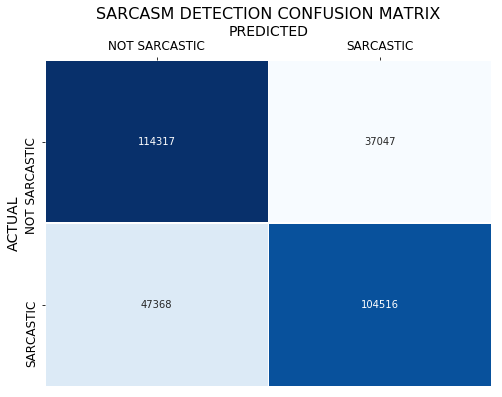

In [76]:
# Plot Confusion Matrix

cm = pd.DataFrame(confusion_matrix(y_test,predictions), index=['NOT SARCASTIC','SARCASTIC'],columns=['NOT SARCASTIC','SARCASTIC'])

fig = plt.figure(figsize=(8,6))
ax = sns.heatmap(cm,annot=True,cbar=False, cmap='Blues',linewidths=0.5,fmt='.0f')
ax.set_title('SARCASM DETECTION CONFUSION MATRIX',fontsize=16,y=1.25)
ax.set_ylabel('ACTUAL',fontsize=14)
ax.set_xlabel('PREDICTED',fontsize=14)
ax.xaxis.set_ticks_position('top')
ax.xaxis.set_label_position('top')
ax.tick_params(labelsize=12)

# Visual of model and lets predict

In [78]:
import eli5

# Coefficients to the Log Odds
eli5.show_weights(estimator=chosen_model.named_steps['logit'],vec = chosen_model.named_steps['tfidf'],top=100)


Weight?,Feature
+9.962,yes because
+9.382,clearly
+9.214,obviously
+8.260,because
+8.161,yeah because
+8.055,totally
+6.297,how dare
+5.971,duh
+5.750,good thing
+5.712,everyone know


## Lets now analyze some predictions!

#### y=0 Not Sarcastic, y=1 Sarcastic. The opacity of the green and red colours indicate the contribution towards the bias y=0 or y=1 and the scores are the log-odds of y=0 or y=1 as shown.

In [81]:
#Non-Sarcastic Comments, y=0¶
eli5.show_prediction(doc=df.iloc[283341,1],
                     estimator=chosen_model.named_steps['logit'],
                     vec = chosen_model.named_steps['tfidf'])

In [84]:
eli5.show_prediction(doc=df.iloc[78020,1],
                     estimator=chosen_model.named_steps['logit'],
                     vec = chosen_model.named_steps['tfidf'])

In [85]:
#Sarcastic comments
eli5.show_prediction(doc=df.iloc[932617,1],
                     estimator=chosen_model.named_steps['logit'],
                     vec = chosen_model.named_steps['tfidf'])


In [86]:
eli5.show_prediction(doc=df.iloc[1009305,1],
                     estimator=chosen_model.named_steps['logit'],
                     vec = chosen_model.named_steps['tfidf'])

## Now lets predict some sarcasm with our model :)

In [124]:
full_df1 = pd.read_csv("predict.csv")

df1 = full_df1[["text"]]
df1["text"] = df1["text"].astype(str) #declaring the contents in the col --
#--> "text" as a string variable.

full_df1.head() # lets see what our rows and cols look like.

,text
0,great rally in colorado thank you will be back...
1,this makes mini mike look good compared to his...
2,its freezing and snowing in new york we need g...
3,she seems like a very happy young girl looking...


In [125]:
eli5.show_prediction(doc=df1.iloc[0,0],
                     estimator=chosen_model.named_steps['logit'],
                     vec = chosen_model.named_steps['tfidf'])

In [126]:
eli5.show_prediction(doc=df1.iloc[1,0],
                     estimator=chosen_model.named_steps['logit'],
                     vec = chosen_model.named_steps['tfidf'])

In [127]:
eli5.show_prediction(doc=df1.iloc[2,0],
                     estimator=chosen_model.named_steps['logit'],
                     vec = chosen_model.named_steps['tfidf'])

In [128]:
eli5.show_prediction(doc=df1.iloc[3,0],
                     estimator=chosen_model.named_steps['logit'],
                     vec = chosen_model.named_steps['tfidf'])